This tutorial will guide you through the process of analyzing your textual data with following steps:
1. Pre-processing
2. Applying topic modelling algorithms
3. Evaluate the topic model manually and automatically

We will also analyze few of the topic modelling applications through visualization. 

In [2]:
import gensim
import os, re
import numpy as np
import pandas as pd
import pyLDAvis.gensim

import nltk
nltk.download('wordnet') # download wordnet to be used in lemmatization
from nltk.stem import WordNetLemmatizer

from gensim.models.word2vec import Text8Corpus
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
from gensim.corpora import Dictionary
from gensim.models.callbacks import CoherenceMetric, DiffMetric, PerplexityMetric, ConvergenceMetric
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

import matplotlib.pyplot as plt
import plotly.offline as py
from plotly.graph_objs import *
import plotly.figure_factory as ff

py.init_notebook_mode()

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /Users/parul/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We will use the [fake news dataset](https://www.kaggle.com/mrisdal/fake-news) from kaggle for this notebook.

## Pre-process

This is one of the most important step in analyzing the text data. If the preprocessing is not good, the algorithm can't do much since we are feeding it a lot of noise, or in other words, **Garbage In Garbage Out**. So let's first clean our data using the following techniques:

1. Stopword removal
2. Strip punctuation
3. Bigram collocation detection. (Bigrams are sets of two adjacent words. Using bigrams, phrases like "machine_learning" can be discovered in our output which otherwise would have been treated as two separate words "machine" and "learning". Spaces are replaced with underscores in corpus)
4. Lemmatization (converting word to its dictionary form)

In [3]:
df_fake = pd.read_csv('fake.csv')
df_fake[['title', 'text', 'language']].head()
df_fake = df_fake.loc[(pd.notnull(df_fake.text)) & (df_fake.language == 'english')]

# Convert data to tokenized list as required by gensim
texts = []
for line in df_fake.text:
    lowered = line.lower()
    words = re.findall(r'\w+', lowered, flags = re.UNICODE | re.LOCALE)
    texts.append(words)

# for bigram collocation detection
bigram = gensim.models.Phrases(texts)

In [7]:
bigram[['hillary', 'clinton', 'democratic']]

/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/gensim-2.3.0-py3.4-macosx-10.6-intel.egg/gensim/models/phrases.py:316: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



['hillary_clinton', 'democratic']

In [8]:
def preprocess(texts):
    # remove stopwords
    texts = [remove_stopwords(' '.join(line)).split() for line in texts]
    # remove punctuation
    texts = [strip_punctuation(' '.join(line)).split() for line in texts]
    # remove words that are only one character
    texts = [[token for token in line if len(token) > 1] for line in texts]
    # collocation detection
    texts = [bigram[line] for line in texts]
    # lemmatization 
    lemmatizer = WordNetLemmatizer()
    texts = [[word for word in lemmatizer.lemmatize(' '.join(line), pos='v').split()] for line in texts]
    
    return texts

# pre-processing
texts = preprocess(texts)

# split into training, holdout and test data
training_texts = texts[:5000]
holdout_texts = texts[5000:7500]
test_texts = texts[7500:]

/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/gensim-2.3.0-py3.4-macosx-10.6-intel.egg/gensim/models/phrases.py:316: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



We now remove rare words and common words based on their document frequency to further prevent noisy results. Below we remove words that appear in less than 10 documents or in more than 60% of the documents.

In [9]:
# create dictionary mappings for training data
dictionary = Dictionary(training_texts)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.6)

Finally, we transform the documents to a vectorized form. We simply compute the frequency of each word, including the bigrams.

In [10]:
training_corpus = [dictionary.doc2bow(text) for text in training_texts]
holdout_corpus = [dictionary.doc2bow(text) for text in holdout_texts]
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

Let's see how our final corpus looks like in vectorized form.

In [11]:
training_corpus[0]

[(385, 1),
 (389, 1),
 (392, 1),
 (730, 1),
 (884, 1),
 (935, 1),
 (1248, 1),
 (1404, 1),
 (2338, 2),
 (2396, 1),
 (2750, 1),
 (4411, 1),
 (4533, 1),
 (4669, 1),
 (4829, 1),
 (6144, 1),
 (6266, 1),
 (6334, 1),
 (6415, 1),
 (6631, 1),
 (9543, 1),
 (10092, 2),
 (11023, 1),
 (11811, 1),
 (12609, 1),
 (13088, 1),
 (13228, 1),
 (13231, 1),
 (13898, 1),
 (13915, 1),
 (14207, 1),
 (14621, 1)]

A document is represented as a list of tuples of (vocab ID, frequency) for each word.

## Train

Now let's train our topic model which is just a matter of single line with gensim.

But wait! a cool functionality has recently been added to gensim which can be used to monitor the training progress of our topic model. It basically plots the training statistics (using the evaluation metrics: Coherence, Perplexity, Topic difference and Convergence), which can be used to know if our model has been sufficiently trained or there's still a scope of optimizing it more.

We will need to start the Visdom server for visualization:

`python -m visdom.server`

Visdom browser can now be accessed at http://localhost:8097.

To monitor the training, a list of Metrics is passed to the LDA function call for plotting their values live as the training progresses.

In [7]:
# define perplexity callback for hold_out and test corpus
pl_holdout = PerplexityMetric(corpus=holdout_corpus, logger="visdom", title="Perplexity (hold_out)")
pl_test = PerplexityMetric(corpus=test_corpus, logger="visdom", title="Perplexity (test)")

# remaining metrics
ch_umass = CoherenceMetric(corpus=training_corpus, coherence="u_mass", logger="visdom", title="Coherence (u_mass)")
ch_cv = CoherenceMetric(corpus=training_corpus, texts=training_texts, coherence="c_v", logger="visdom", title="Coherence (c_v)")
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="Diff (kullback_leibler)")
convergence_jc = ConvergenceMetric(distance="jaccard", logger="visdom", title="Convergence (jaccard)")

callbacks = [pl_holdout, pl_test, ch_umass, ch_cv, diff_kl, convergence_jc]

In [12]:
# training LDA model
lda_model = LdaModel(corpus=training_corpus, id2word=dictionary, num_topics=35, passes=50 , chunksize=1500, iterations=200, alpha='auto', callbacks=callbacks)

<img src="visdom_graph.png"/>

The four evaluation metrics available for topic models in gensim: Coherence, Perplexity, Topic diff and Convergence. (using separate hold_out and test corpus for evaluating the perplexity). These graphs can be used to decide if it's time to stop the training or not. We can see if the value stops changing after some epochs and that we are able to get the best possible value of metrics for our model.


### Coherence

Coherence measures are generally based on the idea of computing the sum of pairwise scores of top n words w1,...,wn used to describe the topic and measuring the support for co-occurence of these words in reference corpus. There are four coherence measures available in gensim: u_mass, c_v, c_uci, c_npmi. A good model will generate coherent topics, i.e., topics with high coherence scores. Good topics can be described by a short label based on the topic terms they spit out.

### Perplexity

Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. In LDA, topics are described by a probability distribution over vocabulary words. So, perplexity can be used to evaluate the topic-term distribution output by LDA. For a good model, perplexity should be low.

### Topic Difference

Topic Diff calculates the distance between two LDA models. This distance is calculated based on the topics, by either using their probability distribution over vocabulary words (kullback_leibler, hellinger) or by simply using the common vocabulary words between the topics from both model (jaccard). In the heatmap of topic difference above, X-axis define the Epoch no. and Y-axis define the distance between identical topics from consecutive epochs. For ex. a particular cell in the heatmap with values (x=3, y=5, z=0.4) represent the distance(=0.4) between the topic 5 from 3rd epoch and topic 5 from 2nd epoch. With increasing epochs, the distance between the identical topics should decrease.

### Convergence

Convergence is the sum of the difference between all the identical topics from two consecutive epochs. It is basically the sum of column values in the Topic Difference heatmap. The model is said to be converged when the convergence value stops descending with increasing epochs.


We can also log the training statistics or access them after the model is trained, for any other custom use case. You can refer to this notebook for further doc on how to use the API.

Lets look at the topics now have been learnt through the model:

In [11]:
lda_model.show_topics(num_topics=5)  # Showing only the top 5 topics

[(3,
  '0.026*"galacticconnection_com" + 0.021*"adhd" + 0.015*"david_stockman" + 0.014*"mail" + 0.014*"join" + 0.013*"psychic_protection" + 0.010*"jurisdiction" + 0.009*"contra_corner" + 0.009*"express" + 0.008*"lee_adler"'),
 (20,
  '0.067*"brain_force" + 0.059*"infowars_com" + 0.056*"http_www" + 0.036*"health" + 0.035*"widget" + 0.035*"force_html" + 0.035*"utm_medium" + 0.035*"wellness_infowars" + 0.035*"ims_tzrwu" + 0.035*"infowars_placement"'),
 (2,
  '0.006*"2016" + 0.005*"video" + 0.005*"story" + 0.004*"man" + 0.004*"women" + 0.004*"news" + 0.004*"woman" + 0.003*"posted" + 0.003*"film" + 0.003*"police"'),
 (34,
  '0.009*"time" + 0.008*"people" + 0.008*"life" + 0.007*"world" + 0.006*"earth" + 0.005*"god" + 0.004*"great" + 0.004*"way" + 0.004*"like" + 0.004*"planet"'),
 (14,
  '0.026*"people" + 0.022*"like" + 0.021*"know" + 0.020*"think" + 0.017*"going" + 0.013*"want" + 0.010*"way" + 0.010*"time" + 0.010*"said" + 0.008*"ve"')]

Other topic modelling algorithms available in gensim:

In [9]:
# decompose the original matrix of words to maintain key topics
lsi_model = LsiModel(corpus=training_corpus, num_topics=35, id2word=dictionary)
lsi_model.show_topics(num_topics=5)

[(0,
  '0.317*"people" + 0.252*"trump" + 0.173*"said" + 0.168*"clinton" + 0.155*"like" + 0.142*"world" + 0.136*"time" + 0.120*"know" + 0.118*"hillary_clinton" + 0.117*"war"'),
 (1,
  '0.523*"trump" + 0.276*"clinton" + -0.218*"arabs" + -0.213*"jewish" + -0.187*"arab" + 0.177*"hillary_clinton" + 0.155*"donald_trump" + 0.143*"election" + -0.140*"jews" + 0.140*"hillary"'),
 (2,
  '-0.280*"arabs" + 0.268*"people" + -0.241*"arab" + -0.226*"jewish" + 0.224*"god" + -0.188*"clinton" + -0.183*"trump" + -0.148*"palestine" + -0.148*"war" + 0.148*"know"'),
 (3,
  '-0.412*"trump" + 0.336*"syria" + 0.267*"russia" + -0.205*"jewish" + -0.205*"arabs" + 0.190*"war" + -0.169*"arab" + -0.168*"donald_trump" + 0.154*"government" + 0.144*"clinton"'),
 (4,
  '0.382*"brain_force" + 0.323*"infowars_com" + 0.301*"http_www" + 0.208*"health" + 0.199*"widget" + 0.199*"infowars_placement" + 0.199*"wellness_infowars" + 0.199*"infowarsstore_com" + 0.199*"utm_campaign" + 0.199*"utm_content"')]

In [10]:
# a completely unsupervised algorithm which figures out the no. of topics on it's own
hdp_model = HdpModel(corpus=training_corpus, id2word=dictionary)
hdp_model.show_topics(num_topics=5)

[(0,
  '0.006*people + 0.006*trump + 0.005*said + 0.004*clinton + 0.003*like + 0.003*time + 0.003*world + 0.003*hillary_clinton + 0.003*government + 0.003*state + 0.003*new + 0.002*2016 + 0.002*election + 0.002*know + 0.002*hillary + 0.002*war + 0.002*president + 0.002*russia + 0.002*country + 0.002*way'),
 (1,
  '0.005*galacticconnection_com + 0.003*join + 0.003*click + 0.003*psychic_protection + 0.002*information + 0.002*2016 + 0.002*access + 0.002*com + 0.002*mail + 0.002*said + 0.002*hillary_clinton + 0.002*added + 0.002*2012 + 0.002*data + 0.002*sign + 0.002*send + 0.002*given + 0.002*irp + 0.002*provided + 0.002*clinton'),
 (2,
  '0.004*said + 0.003*people + 0.003*russia + 0.003*trump + 0.002*clinton + 0.002*isis + 0.002*government + 0.002*mosul + 0.002*2016 + 0.002*police + 0.002*india + 0.002*new + 0.002*officers + 0.001*officials + 0.001*russian + 0.001*time + 0.001*hillary_clinton + 0.001*state + 0.001*support + 0.001*office'),
 (3,
  '0.004*said + 0.002*clinton + 0.002*2016 

## Evaluation

### Manual:

We would like to know if the correct thing has been learned, does the topics inferred make sense as per our text data.
Thanks to pyLDAvis, we can visualise our topic models in a really handy way and inspect what words the topics consist of or how similar the topics are.

In [12]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, training_corpus, dictionary, sort_topics=False)

/Users/parul/.virtualenvs/gensim3/lib/python3.4/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       3.653860        1       1  0.071503 -0.056030
1       3.567148        1       2  0.067970 -0.120467
2       5.536422        1       3  0.015874  0.136752
3       0.347600        1       4 -0.243523 -0.061466
4       8.310720        1       5  0.085888  0.076391
5       0.724154        1       6 -0.039547 -0.105262
6       5.760693        1       7  0.116927  0.012774
7       2.694592        1       8  0.038832  0.059330
8       2.894535        1       9  0.068063  0.050590
9       2.003031        1      10  0.037754  0.077344
10     10.240133        1      11  0.155602 -0.131371
11      0.956183        1      12 -0.101366 -0.048841
12      0.619608        1      13 -0.079713 -0.069928
13      0.613262        1      14 -0.164118  0.022038
14      7.747240        1      15  0.111659 -0.044148
15      0.905694        1      16 -0.022022 -0.002166
16      3.544039        1      17  0.100935  0.075347
17      1.514892        1      18 -0.044154  0.176924
18      3.145270        1      19  0.024821  0.019507
19      2.037770        1      20  0.007635  0.012414
20      0.559234        1      21 -0.292035 -0.080170
21      0.224545        1      22 -0.151550 -0.094149
22      1.309624        1      23  0.018165  0.042440
23      0.519350        1      24 -0.237076  0.018968
24      3.646907        1      25  0.047084  0.194083
25      1.936840        1      26  0.104489 -0.204417
26      1.034336        1      27 -0.013626  0.066164
27      0.908821        1      28 -0.021707 -0.042137
28      3.649326        1      29  0.084589 -0.137467
29      2.496487        1      30  0.101789 -0.014288
30      2.945280        1      31  0.006128  0.096015
31      1.499593        1      32  0.050195 -0.085610
32      2.234125        1      33  0.008338  0.223096
33      1.365430        1      34 -0.045418  0.036195
34      8.853256        1      35  0.131618 -0.098451, topic_info=      Category         Freq             Term        Total  loglift  logprob
term                                                                       
8364   Default  7116.000000            trump  7116.000000  30.0000  30.0000
14659  Default  4794.000000          clinton  4794.000000  29.0000  29.0000
10967  Default  3252.000000             2016  3252.000000  28.0000  28.0000
11518  Default  5666.000000             said  5666.000000  27.0000  27.0000
2265   Default  7602.000000           people  7602.000000  26.0000  26.0000
11987  Default  2656.000000           russia  2656.000000  25.0000  25.0000
5396   Default  3334.000000       government  3334.000000  24.0000  24.0000
14476  Default  3046.000000         election  3046.000000  23.0000  23.0000
10385  Default  3655.000000            world  3655.000000  22.0000  22.0000
9720   Default  3439.000000  hillary_clinton  3439.000000  21.0000  21.0000
6319   Default  2744.000000          hillary  2744.000000  20.0000  20.0000
1662   Default  1740.000000              fbi  1740.000000  19.0000  19.0000
3632   Default  1971.000000            syria  1971.000000  18.0000  18.0000
1419   Default  2644.000000     donald_trump  2644.000000  17.0000  17.0000
9868   Default  2116.000000            obama  2116.000000  16.0000  16.0000
13023  Default  2607.000000        president  2607.000000  15.0000  15.0000
2815   Default  1506.000000           emails  1506.000000  14.0000  14.0000
13979  Default  1143.000000           israel  1143.000000  13.0000  13.0000
5528   Default  3087.000000            state  3087.000000  12.0000  12.0000
5297   Default  1178.000000            black  1178.000000  11.0000  11.0000
7516   Default   997.000000              com   997.000000  10.0000  10.0000
7342   Default  2732.000000              war  2732.000000   9.0000   9.0000
9667   Default  2361.000000            think  2361.000000   8.0000   8.0000
13242  Default  4017.000000             like  4017.000000  

#### Left Panel:

1. The area of the circles is proportional to the prevalence of the topics in corpus. So, we can visually determine about the most important topics in our corpus.
2. The positioning of the topics is done according to their inter-topic distances, which to some exent preserves the semantic similarity allowing some related topics to form clusters, it is however a little difficult to determine exactly how similar the topics are. For this, we can directly visualize the matrix of inter-topic distances and know the exact distance (with intersecting/different words) between any pair of topics.

In [13]:
def plot_difference(mdiff, title="", annotation=None):
    """
    Helper function to plot difference between models
    """
    annotation_html = None
    if annotation is not None:
        annotation_html = [["+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                            for (int_tokens, diff_tokens) in row]
                           for row in annotation]
        
    data = Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = Layout(width=950, height=950, title=title,
                       xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [14]:
mdiff, annotation = lda_model.diff(lda_model, distance='jensen_shannon', num_words=50)
plot_difference(mdiff, title="Topic difference [jensen shannon distance]", annotation=annotation)

The inter-topic distances are calculated using (default) Jensen-Shannon divergence in pyLDAvis.
The 2d coordinate which are infered for each topic in the left panel are based on this distance matrix only. [Principal coordinate analysis (PCoA)](https://mb3is.megx.net/gustame/dissimilarity-based-methods/principal-coordinates-analysis) is used for infering the 2d coordinates which seeks to preserve the original topic distances in 2d plane. It first converts the N-dimensional points in given metric’s space (jenson-shannon metric space) into the euclidean space of same dimension and then simply do a PCA on these newly constructed points in euclidean space to bring them down to 2 dimensions. You can also refer to [this](http://occamstypewriter.org/boboh/2012/01/17/pca_and_pcoa_explained/) blog for getting a graphical reasoning behind this technique.


#### Right Panel:

1. The terms are initially ranked according to their saliency (=frequency(w)*[sum_t p(t|w)*log(p(t|w)/p(t)] for topics t), when no topic is selected. Saliency basically depends on frequency of the term, and how informative the specific term w is for determining the individual topics.  For example, if a word w occurs in all topics, observing the word tells us little about the document’s topical mixture <sup>[1]</sup>.
2. The tuning parameter, 0≤λ≤1, controls how the terms are ranked for each selected topic, where terms are listed in decreasing order of relevance, and the relevance of term w to topic t is defined as λ*p(w∣t)+(1−λ)*p(w∣t)/p(w). Values of λ near 1 give high relevance rankings to frequent terms within a given topic, whereas values of λ near zero give high relevance rankings to exclusive terms within a topic.

But how does this ranking relate to the ranking of terms in gensim's `show_topic()` method that we saw above. In gensim, the float value given, next to every term as shown in the list output of `show_topic()` is the value of p(w∣t) i.e. probability of term w for topic t, and gensim simply ranks the topic terms according to this probability value. So, in order to have similar results as gensim’s `show_topic()` in pyLDAvis, λ can be set to 1 which will then result in the relevance being directly proportional to only p(w∣t). 

Now if we choose λ very close to 1, common terms of the corpus appear near the top for multiple topics, making it hard to differentiate between the meanings of these topics. And if choose λ very close to 0, it can still remain noisy, by giving high rankings to very rare terms that occur in only a single topic, for instance. While such terms may contain useful topical content, if they are very rare the topic may remain difficult to interpret.

The optimal value suggested for λ is 0.6<sup>[2]</sup>.



### Automatic:

[Coherence](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) is often used to get past the manual inspection and objectively compare the topic models. By returning a score, we can compare between different topic models of the same corpus.

In [15]:
lsi_coherence = CoherenceModel(lsi_model, texts=training_texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(hdp_model, texts=training_texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(lda_model, texts=training_texts, dictionary=dictionary, window_size=10).get_coherence()

In [22]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

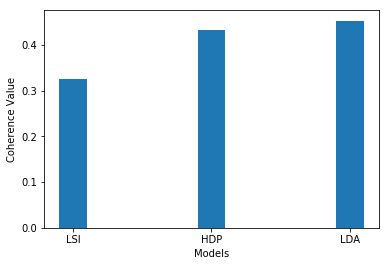

In [24]:
%matplotlib inline
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP', 'LDA'])

Following is a really nice explanation for understanding the intution behind coherence that I came across in Matti Lyra's [Pydata Berlin talk](https://github.com/mattilyra/pydataberlin-2017/blob/master/notebook/EvaluatingUnsupervisedModels.ipynb):

Take the following two documents that talk about ice hockey. I've highlighted terms that I think are related to the subject matter, you may disagree with my judgement. Notice that among the terms that I've highlighted as being part of the topic of Ice Hockey are words such as Penguin, opposing and shots. None of these on the face of it would appear to "belong" to Ice Hockey, but seeing them in context makes it clear that Penguin refers to the ice hockey team, shots refers to disk shaped pieces of vulcanised rubber being launched at the goal at various different speeds and opposing refers to the opposing team although it might more commonly be thought to belong politics or the debate club.
    
> ... began his professional **career** in 1989–90 with **Jokerit** of the **SM-liiga** and **played** 21 **seasons** in the **National Hockey League (NHL)** for the **Winnipeg Jets** ...

> **Rinne stopped** 27 of 28 shots from the **Penguins** in **Game** 6 at home Sunday, but that lone **goal** allowed was enough for the **opposition** to break out the **Stanley Cup trophy** for the second straight **season**.

Given the terms that I've determined to be a partial description of Ice Hockey (the concept), one could conceivably measure the coherence of that concept by counting how many times those terms occur with each other i.e. co-occur in some sufficiently large reference corpus.

One of course encounters a problem should the reference corpus never refer to ice hockey. A poorly selected reference corpus could for instance be patent applications from the 1800s, it would be unlikely to find those word pairs in that text.

This is precisely what several research papers have aimed to do. To take the top words from the topics in a topic model and measure the support for those words forming a coherent concept / topic by looking at the co-occurrences of those terms in a reference corpus. The research up to now was finally wrapped up into a single paper where the authors develop a coherence pipeline, which allows plugging in all the different methods into a single framework. This coherence pipeline is partially implemented in gensim, below is a few examples on how to use it.

## Application

In this section, we will go through some of the applications or ways in which we can use topic models and get the most out of them for our NLP tasks.


### Document clustering

Now apart from getting the topic distribution of a corpus as a whole (as we did using `show_topics`) we can also get the topic distribution of individual documents using `get_document_topics`. Let's see an example for doing it in gensim and then we will visualize the documents based on their topic distribution.

In [13]:
# Get document topics
all_topics = lda_model.get_document_topics(training_corpus, minimum_probability=0)
all_topics[0]

[(0, 0.020668621306056959),
 (1, 0.00068393442964218476),
 (2, 0.0015616974718069003),
 (3, 0.0021664881213202926),
 (4, 0.063494549309583662),
 (5, 0.47969297478758849),
 (6, 0.00033849909515112632),
 (7, 0.0032132009642057528),
 (8, 0.00085709882499484039),
 (9, 0.001440106953497153),
 (10, 0.0041610367466473844),
 (11, 0.0025388100590111378),
 (12, 0.0024019417364068967),
 (13, 0.0041256792079179105),
 (14, 0.0024508843292253141),
 (15, 0.0016649373865829005),
 (16, 0.0030716168181256212),
 (17, 0.0015041791090443467),
 (18, 0.015371524601851583),
 (19, 0.0016813910018547863),
 (20, 0.1819355853229066),
 (21, 0.0028975904436628263),
 (22, 0.022060284389490269),
 (23, 0.0025442199461290053),
 (24, 0.0010534924818779005),
 (25, 0.0019191257146545866),
 (26, 0.0012863072070121576),
 (27, 0.0022422866904890956),
 (28, 0.0030796294830178188),
 (29, 0.0013405327195320643),
 (30, 0.0036553253106619307),
 (31, 0.0016829446952157212),
 (32, 0.00063696788616286542),
 (33, 0.001116525441849409

The above output shows the topic distribution of first document in the corpus as a list of (topic_id, topic_probability).

Now, using the topic distribution of a document as it's vector embedding, we will plot all the documents in our corpus using Tensorboard.

#### Prepare the Input files for Tensorboard

Tensorboard takes two input files, one containing the embedding vectors and the other containing relevant metadata. As described above we will use the topic distribution of documents as their embedding vector. Metadata file will consist of Doc Ids.

In [16]:
# create file for tensors
with open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
with open('doc_lda_metadata.tsv','w') as w:
    for doc_id in range(len(all_topics)):
        w.write("doc_" + str(doc_id) + "\n")

Now we can go to http://projector.tensorflow.org/ and upload these two files by clicking on Load data in the left panel.

Next, we will append the topics with highest probability (topic_id, topic_probability) to the document's title, in order to explore what topics do the cluster corners or edges dominantly belong to. For this, we just need to overwrite the metadata file as below:

In [22]:
tensors = []
for doc_topics in all_topics:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

# overwrite metadata file
with open('doc_lda_metadata.tsv','w') as w:
    w.write("Doc_id\tTopic_dist\n")
    for doc_id in range(0, len(all_topics)):
        w.write("doc_%s\t%s\n" % (str(doc_id), str(tensors[doc_id])))

Upload the previous tensor file "doc_lda_tensor.tsv" and this new metadata file to http://projector.tensorflow.org/ .

### Topic Connections

Topic connections are extremely useful especially in areas with interdisciplinary interests, one wide application for topic connections can be seen in semanticscholar.org where they use interrelated topics to index scientific papers.

#### Topic Network

Networks can be a great way to explore topic models. We can use it to navigate that how topics belonging to one context may relate to some topics in other context and discover common factors between them. We can use them to find communities of similar topics and pinpoint the most influential topic that has large no. of connections or perform any number of other workflows designed for network analysis.

Firstly, a distance matrix is calculated to store distance between every topic pair. The nodes of the network graph will represent topics and the edges between them will be created based on the distance between two connecting nodes/topics.

In [26]:
# get topic distributions
topic_dist = lda_model.state.get_lambda()

# get topic terms
num_words = 50
topic_terms = [{w for (w, _) in lda_model.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

To draw the edges, we can use different types of distance metrics available in gensim for calculating the distance between every topic pair. Next, we'd have to define a threshold of distance value such that the topic-pairs with distance above that does not get connected.

In [27]:
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon
import networkx as nx
import itertools as itt

# calculate distance matrix using the input distance metric
def distance(X, dist_metric):
    return squareform(pdist(X, lambda u, v: dist_metric(u, v)))

topic_distance = distance(topic_dist, jensen_shannon)

# store edges b/w every topic pair along with their distance
edges = [(i, j, {'weight': topic_distance[i, j]})
         for i, j in itt.combinations(range(topic_dist.shape[0]), 2)]

# keep edges with distance below the threshold value
k = np.percentile(np.array([e[2]['weight'] for e in edges]), 20)
edges = [e for e in edges if e[2]['weight'] < k]

Now that we have our edges, let's plot the annotated network graph. On hovering over the nodes, we'll see the topic_id along with it's top words and on hovering over the edges, we'll see the intersecting/different words of the two topics that it connects.

In [29]:
# add nodes and edges to graph layout
G = nx.Graph()
G.add_nodes_from(range(topic_dist.shape[0]))
G.add_edges_from(edges)

graph_pos = nx.spring_layout(G)

# initialize traces for drawing nodes and edges 
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            xanchor='left'
        ),
        line=dict(width=2)))

edge_trace = Scatter(
    x=[],
    y=[],
    text=[],
    line=Line(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')


# no. of terms to display in annotation
n_ann_terms = 10

# add edge trace with annotations
for edge in G.edges():
    x0, y0 = graph_pos[edge[0]]
    x1, y1 = graph_pos[edge[1]]
    
    pos_tokens = topic_terms[edge[0]] & topic_terms[edge[1]]
    neg_tokens = topic_terms[edge[0]].symmetric_difference(topic_terms[edge[1]])
    pos_tokens = list(pos_tokens)[:min(len(pos_tokens), n_ann_terms)]
    neg_tokens = list(neg_tokens)[:min(len(neg_tokens), n_ann_terms)]
    annotation = "<br>".join((": ".join(("+++", str(pos_tokens))), ": ".join(("---", str(neg_tokens)))))
    
    x_trace = list(np.linspace(x0, x1, 10))
    y_trace = list(np.linspace(y0, y1, 10))
    text_annotation = [annotation] * 10
    x_trace.append(None)
    y_trace.append(None)
    text_annotation.append(None)
    
    edge_trace['x'] += x_trace
    edge_trace['y'] += y_trace
    edge_trace['text'] += text_annotation

# add node trace with annotations
for node in G.nodes():
    x, y = graph_pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_info = ''.join((str(node+1), ': ', str(list(topic_terms[node])[:n_ann_terms])))
    node_trace['text'].append(node_info)
    
# color node according to no. of connections
for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(showlegend=False,
                hovermode='closest',
                xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=True)))

py.iplot(fig)

For the above graph, we just used the 20th percentile of all the distance values as our threshold. But we can experiment with few different values also such that the graph doesn’t become too crowded or too sparse and we could get an optimum amount of information about similar topics or any interesting relations b/w different topics.

### Topic dendrogram

Sometimes the topics can be related to each other in a hierarchical form also. For ex. in case of a research paper corpora, we could have papers belonging to maths, physics, bio which can further be categorised into sub-groups. Maths papers can be sub-divided into topics such as Calculus, Algebra, Geometry etc. Physics papers into mechanics, electronics, astronomy etc. and so on for bio.

Dendrogram is a tree-structured graph which can be used to visualize the result of a hierarchical clustering calculation. Hierarchical clustering puts individual data points into similarity groups, without prior knowledge of groups. We can use it to explore the topic models and see how the topics are connected to each other in a sequence of successive fusions or divisions that occur in the clustering process.

In [30]:
from scipy import spatial as scs
from scipy.cluster import hierarchy as sch


# get topic distributions
topic_dist = lda_model.state.get_lambda()

# get topic terms
num_words = 300
topic_terms = [{w for (w, _) in lda_model.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

# no. of terms to display in annotation
n_ann_terms = 10

# use Jensen-Shannon distance metric in dendrogram
def js_dist(X):
    return pdist(X, lambda u, v: jensen_shannon(u, v))

# define method for distance calculation in clusters
linkagefun=lambda x: sch.linkage(x, 'single')

# calculate text annotations
def text_annotation(topic_dist, topic_terms, n_ann_terms, linkagefun):
    # get dendrogram hierarchy data
    linkagefun = lambda x: sch.linkage(x, 'single')
    d = js_dist(topic_dist)
    Z = linkagefun(d)
    P = sch.dendrogram(Z, orientation="bottom", no_plot=True)

    # store topic no.(leaves) corresponding to the x-ticks in dendrogram
    x_ticks = np.arange(5, len(P['leaves']) * 10 + 5, 10)
    x_topic = dict(zip(P['leaves'], x_ticks))

    # store {topic no.:topic terms}
    topic_vals = dict()
    for key, val in x_topic.items():
        topic_vals[val] = (topic_terms[key], topic_terms[key])

    text_annotations = []
    # loop through every trace (scatter plot) in dendrogram
    for trace in P['icoord']:
        fst_topic = topic_vals[trace[0]]
        scnd_topic = topic_vals[trace[2]]
        
        # annotation for two ends of current trace
        pos_tokens_t1 = list(fst_topic[0])[:min(len(fst_topic[0]), n_ann_terms)]
        neg_tokens_t1 = list(fst_topic[1])[:min(len(fst_topic[1]), n_ann_terms)]

        pos_tokens_t4 = list(scnd_topic[0])[:min(len(scnd_topic[0]), n_ann_terms)]
        neg_tokens_t4 = list(scnd_topic[1])[:min(len(scnd_topic[1]), n_ann_terms)]

        t1 = "<br>".join((": ".join(("+++", str(pos_tokens_t1))), ": ".join(("---", str(neg_tokens_t1)))))
        t2 = t3 = ()
        t4 = "<br>".join((": ".join(("+++", str(pos_tokens_t4))), ": ".join(("---", str(neg_tokens_t4)))))

        # show topic terms in leaves
        if trace[0] in x_ticks:
            t1 = str(list(topic_vals[trace[0]][0])[:n_ann_terms])
        if trace[2] in x_ticks:
            t4 = str(list(topic_vals[trace[2]][0])[:n_ann_terms])

        text_annotations.append([t1, t2, t3, t4])

        # calculate intersecting/diff for upper level
        intersecting = fst_topic[0] & scnd_topic[0]
        different = fst_topic[0].symmetric_difference(scnd_topic[0])

        center = (trace[0] + trace[2]) / 2
        topic_vals[center] = (intersecting, different)

        # remove trace value after it is annotated
        topic_vals.pop(trace[0], None)
        topic_vals.pop(trace[2], None)  
        
    return text_annotations

# get text annotations
annotation = text_annotation(topic_dist, topic_terms, n_ann_terms, linkagefun)

# Plot dendrogram
dendro = ff.create_dendrogram(topic_dist, distfun=js_dist, labels=range(1, 36), linkagefun=linkagefun, hovertext=annotation)
dendro['layout'].update({'width': 1000, 'height': 600})
py.iplot(dendro)

The x-axis or the leaves of hierarchy represent the topics of our LDA model, y-axis is a measure of closeness of either individual topics or their cluster. Essentially, the y-axis level at which the branches merge (relative to the "root" of the tree) is related to their similarity. For ex., topic 25 and 33 are more similar to each other than to topic 17. In addition, topic 15 and 35 are more similar to 11 than topic 25 and 33 are to each other as the height on which they merge is lower than the merge height of 15/35 to 11.

Text annotations visible on hovering over the cluster nodes show the intersecting/different terms of it's two child nodes. Cluster node on first hierarchy level uses the topics on leaves directly to calculate intersecting/different terms, and the upper nodes assume the intersection(+++) as the topic terms of it's child node.

This type of tree graph could help us see the high level cluster theme that might exist in our data as we can see the common/different terms of combined topics in a cluster head annotation.

## References

1. http://vis.stanford.edu/files/2012-Termite-AVI.pdf
2. https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf